In [1]:
import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F

# d_output = 161

tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

d_output = train_cfg['d_output'] 

backbone = DNAEmbeddingModel(**model_cfg)

decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/last.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
# loads model from ddp by removing prexix to single if necessary
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)

model_state_dict = state_dict["state_dict"]

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

#now adjust the backbone
embedding = torch.nn.Embedding(20, 128)
backbone.backbone.embeddings.word_embeddings = embedding #again a hack

# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)

decoder = decoder.to(device)
backbone = backbone.to(device)

#for some reason on the lu machine complains torchvision and torch on different versions? very annoying!

In [9]:
#let's define a class that takes both elements
class Net(torch.nn.Module):
    def __init__(self, backbone, decoder):
        super(Net, self).__init__()
        self.backbone = backbone  # Your pre-defined backbone
        self.decoder = decoder    # Your pre-defined decoder

    def forward(self, x):
        x, _ = self.backbone(x)  # Pass input through backbone
        x = self.decoder(x)   # Pass backbone's output through decoder
        return x

In [10]:
net = Net(backbone, decoder).to(device)

In [11]:
#now we can use the net to make predictions
a,b = ccre[0]
print(a.shape)
a = a.unsqueeze(0).to(device) #add batch dimension
print(a.shape) 
print(b.shape)

torch.Size([1023])
torch.Size([1, 1023])
torch.Size([1])


In [14]:
out = net(a)
print(out.shape)
print(out)
print(b)

torch.Size([1, 1])
tensor([[-1.5781]], grad_fn=<AddmmBackward0>)
tensor([-10.])


In [15]:
with torch.no_grad():
    out = net(a)
print(out) #now doesn't have the grad_fn

tensor([[-1.3763]])


In [16]:
#let's try deepLIFT via deepshap
import shap
loader = torch.utils.data.DataLoader(ccre, batch_size=10, shuffle=False, num_workers=0)
batch = next(iter(loader))
inputs, targets = batch
inputs = inputs.to(device)

# Initialize DeepSHAP
background = inputs[:9]
test_input = inputs[9]
explainer = shap.DeepExplainer(net, background)

RuntimeError: Tensors must have same number of dimensions: got 1 and 2

In [17]:
shap_values = explainer.shap_values(test_input.unsqueeze(0))

RuntimeError: only Tensors of floating point dtype can require gradients

In [21]:
inputs.dtype


torch.int64

In [22]:
a,b = ccre[0]
print(a.dtype)

torch.int64


In [23]:
#repeat but make it a float
loader = torch.utils.data.DataLoader(ccre, batch_size=10, shuffle=False, num_workers=0)
batch = next(iter(loader))
inputs, targets = batch
inputs = inputs.to(device)
#make inputs float32
inputs = inputs.float()

# Initialize DeepSHAP
background = inputs[:9]
test_input = inputs[9]
explainer = shap.DeepExplainer(net, background) #my model requires int of course, but deepshap requires float, not sure how to fix this

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [25]:
a[0:8] #first 7 are the unique tokens, 8th is the starting token

tensor([12, 13, 14, 15, 16, 17, 18,  7])

In [33]:
print(backbone.backbone.embeddings.word_embeddings(a).dtype) #this is indeed a float
print(backbone.backbone.embeddings.word_embeddings(a).shape)

torch.float32
torch.Size([1023, 128])


In [ ]:
#the real thing is we need to not start from the tokens but rather the embeddings


# visualizing the embeddings

In [34]:
#let's get the embeddings
embed = backbone.backbone.embeddings.word_embeddings.weight
print(embed.shape)

torch.Size([20, 128])


In [35]:
#now do pca and plot
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(embed.detach().numpy())
pca_embed = pca.transform(embed.detach().numpy())
print(pca_embed.shape)

(20, 2)


In [38]:
tokenizer._vocab_int_to_str #also has str to int, they're the same thing

{0: '[CLS]',
 1: '[SEP]',
 2: '[BOS]',
 3: '[MASK]',
 4: '[PAD]',
 5: '[RESERVED]',
 6: '[UNK]',
 7: 'A',
 8: 'C',
 9: 'G',
 10: 'T',
 11: 'N',
 12: 'S',
 13: 'U',
 14: 'V',
 15: 'W',
 16: 'X',
 17: 'Y',
 18: 'Z'}

20


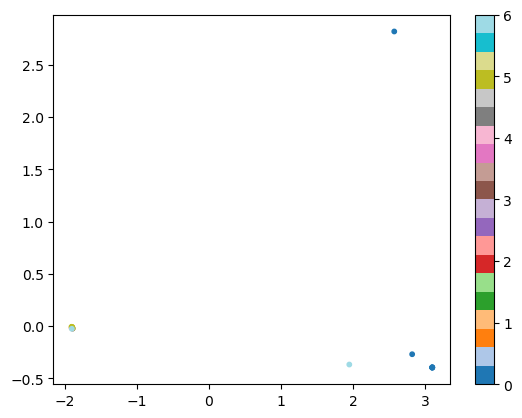

In [47]:
c = [0,0,0,0,0,0,0,1,2,3,4,6,5,5,5,5,5,5,5,6]
print(len(c))
plt.scatter(pca_embed[:,0], pca_embed[:,1], c=c, s = 10, cmap='tab20')
plt.colorbar()

In [46]:
print(tokenizer._vocab_int_to_str)
print(pca_embed)

#all the special tokens are placed in the positive x axis all over the place, the rest are in the negative x axis
#the eos token is way off on its own too.

{0: '[CLS]', 1: '[SEP]', 2: '[BOS]', 3: '[MASK]', 4: '[PAD]', 5: '[RESERVED]', 6: '[UNK]', 7: 'A', 8: 'C', 9: 'G', 10: 'T', 11: 'N', 12: 'S', 13: 'U', 14: 'V', 15: 'W', 16: 'X', 17: 'Y', 18: 'Z'}
[[ 3.1009896  -0.39669225]
 [ 2.57326     2.819292  ]
 [ 3.1009896  -0.3966933 ]
 [ 3.10099    -0.39669278]
 [ 3.1009886  -0.39669308]
 [ 3.10099    -0.3966926 ]
 [ 2.8220198  -0.26992196]
 [-1.9098815  -0.02023822]
 [-1.9044915  -0.01625261]
 [-1.895745   -0.0245558 ]
 [-1.9110132  -0.01479941]
 [ 1.9488039  -0.3684895 ]
 [-1.9025818  -0.01456524]
 [-1.9011172  -0.00978847]
 [-1.9108661  -0.00732211]
 [-1.9043951  -0.01082938]
 [-1.9026681  -0.0184322 ]
 [-1.8946012  -0.02131293]
 [-1.9053768  -0.01300538]
 [-1.9062933  -0.0263147 ]]


In [50]:
#let's print the proper ones
indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
# print([tokenizer._vocab_int_to_str[i] for i in indices])
for i in indices:
    print(tokenizer._vocab_int_to_str[i], pca_embed[i]) #sep was actually the eos token, the rest were unseen
    #N also is positive nad placed elsewhere, the rest are placed random places all super close together

[CLS] [ 3.1009896  -0.39669225]
[SEP] [2.57326  2.819292]
[BOS] [ 3.1009896 -0.3966933]
[MASK] [ 3.10099    -0.39669278]
[PAD] [ 3.1009886  -0.39669308]
[RESERVED] [ 3.10099   -0.3966926]
[UNK] [ 2.8220198  -0.26992196]
A [-1.9098815  -0.02023822]
C [-1.9044915  -0.01625261]
G [-1.895745  -0.0245558]
T [-1.9110132  -0.01479941]
N [ 1.9488039 -0.3684895]
S [-1.9025818  -0.01456524]
U [-1.9011172  -0.00978847]
V [-1.9108661  -0.00732211]
W [-1.9043951  -0.01082938]
X [-1.9026681 -0.0184322]
Y [-1.8946012  -0.02131293]
Z [-1.9053768  -0.01300538]


(-0.1, 0.1)

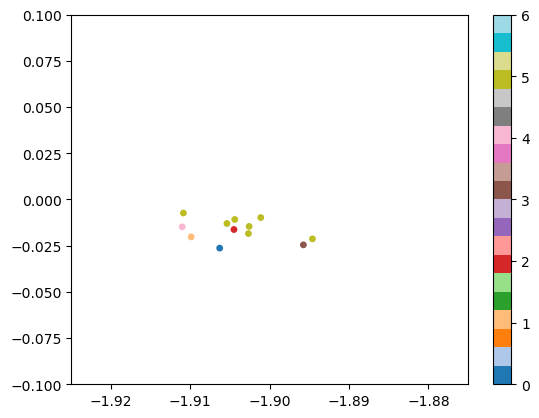

In [58]:
c = [0,0,0,0,0,0,0,1,2,3,4,6,5,5,5,5,5,5,5,0]
plt.scatter(pca_embed[:,0], pca_embed[:,1], s = 15, cmap='tab20', c = c)
plt.colorbar()
plt.xlim(-1.925, -1.875)
plt.ylim(-.1, .1)

#again we reduced dimensionality heavily, so maybe not the most accurate, but it's pretty noisy, nothing special

In [61]:
#let's test some of the stuf flike how we can ignore th eembeddings
# for layer in backbone.backbone.encoder.layers:
#     print(layer)
print(backbone)
backbone.forward

DNAEmbeddingModel(
  (backbone): LMBackbone(
    (embeddings): GPT2Embeddings(
      (word_embeddings): Embedding(20, 128)
    )
    (layers): ModuleList(
      (0): Block(
        (mixer): HyenaOperator(
          (activation): Identity()
          (dropout): Dropout(p=0.0, inplace=False)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (in_proj): Linear(in_features=128, out_features=384, bias=True)
          (short_filter): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,), groups=384)
          (filter_fn): HyenaFilter(
            (dropout): Dropout(p=0.0, inplace=False)
            (pos_emb): PositionalEmbedding()
            (implicit_filter): Sequential(
              (0): Linear(in_features=5, out_features=64, bias=True)
              (1): Sin()
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): Sin()
              (4): Linear(in_features=64, out_features=64, bias=True)
              (5): Sin()

<bound method DNAEmbeddingModel.forward of DNAEmbeddingModel(
  (backbone): LMBackbone(
    (embeddings): GPT2Embeddings(
      (word_embeddings): Embedding(20, 128)
    )
    (layers): ModuleList(
      (0): Block(
        (mixer): HyenaOperator(
          (activation): Identity()
          (dropout): Dropout(p=0.0, inplace=False)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (in_proj): Linear(in_features=128, out_features=384, bias=True)
          (short_filter): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,), groups=384)
          (filter_fn): HyenaFilter(
            (dropout): Dropout(p=0.0, inplace=False)
            (pos_emb): PositionalEmbedding()
            (implicit_filter): Sequential(
              (0): Linear(in_features=5, out_features=64, bias=True)
              (1): Sin()
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): Sin()
              (4): Linear(in_features=64, out_featu

In [67]:
backbone.children().__next__()

LMBackbone(
  (embeddings): GPT2Embeddings(
    (word_embeddings): Embedding(20, 128)
  )
  (layers): ModuleList(
    (0): Block(
      (mixer): HyenaOperator(
        (activation): Identity()
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
        (in_proj): Linear(in_features=128, out_features=384, bias=True)
        (short_filter): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,), groups=384)
        (filter_fn): HyenaFilter(
          (dropout): Dropout(p=0.0, inplace=False)
          (pos_emb): PositionalEmbedding()
          (implicit_filter): Sequential(
            (0): Linear(in_features=5, out_features=64, bias=True)
            (1): Sin()
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): Sin()
            (4): Linear(in_features=64, out_features=64, bias=True)
            (5): Sin()
            (6): Linear(in_features=64, out_features=128, bias=False)
    

In [69]:
for layer in backbone:
    print(layer)
    print('---')

TypeError: 'DNAEmbeddingModel' object is not iterable

In [75]:
backbone.backbone

LMBackbone(
  (embeddings): GPT2Embeddings(
    (word_embeddings): Embedding(20, 128)
  )
  (layers): ModuleList(
    (0): Block(
      (mixer): HyenaOperator(
        (activation): Identity()
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
        (in_proj): Linear(in_features=128, out_features=384, bias=True)
        (short_filter): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,), groups=384)
        (filter_fn): HyenaFilter(
          (dropout): Dropout(p=0.0, inplace=False)
          (pos_emb): PositionalEmbedding()
          (implicit_filter): Sequential(
            (0): Linear(in_features=5, out_features=64, bias=True)
            (1): Sin()
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): Sin()
            (4): Linear(in_features=64, out_features=64, bias=True)
            (5): Sin()
            (6): Linear(in_features=64, out_features=128, bias=False)
    

In [81]:
backbone.backbone.layers
#also drop_f and ln_f need to be run!

ModuleList(
  (0): Block(
    (mixer): HyenaOperator(
      (activation): Identity()
      (dropout): Dropout(p=0.0, inplace=False)
      (out_proj): Linear(in_features=128, out_features=128, bias=True)
      (in_proj): Linear(in_features=128, out_features=384, bias=True)
      (short_filter): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,), groups=384)
      (filter_fn): HyenaFilter(
        (dropout): Dropout(p=0.0, inplace=False)
        (pos_emb): PositionalEmbedding()
        (implicit_filter): Sequential(
          (0): Linear(in_features=5, out_features=64, bias=True)
          (1): Sin()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Sin()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): Sin()
          (6): Linear(in_features=64, out_features=128, bias=False)
        )
        (modulation): ExponentialModulation()
      )
    )
    (dropout1): Dropout(p=0.1, inplace=False)
    (drop_path1): Stochast

In [85]:
a,b = ccre[0]
a_embed = backbone.backbone.embeddings.word_embeddings(a.unsqueeze(0))
out_test = backbone.backbone.layers[0](a_embed)
print(out_test[0].shape)
print(out_test[1].shape)

#we'd have to recreate the forward function, not that hard, just awfully annoying, also why are ther etwo outputs??

torch.Size([1, 1023, 128])
torch.Size([1, 1023, 128])


In [86]:
backbone.backbone.fused_dropout_add_ln #so goes into the first part of th eloop

False

In [ ]:
#there's a residual
residual = None
for layer in backbone.backbone.layers:
    a_embed, residual = layer(a_embed, residual)
dropped = backbone.backbone.drop_f(a_embed)
residual = (dropped + residual) if residual is not None else dropped
hidden_states = self.ln_f(residual.to(dtype=self.ln_f.weight.dtype))

In [ ]:
#and the rest
# if not self.fused_dropout_add_ln:
#     dropped = self.drop_f(hidden_states)
#     residual = (dropped + residual) if residual is not None else dropped
#     hidden_states = self.ln_f(residual.to(dtype=self.ln_f.weight.dtype))
# else:
#     # Set prenorm=False here since we don't need the residual
#     hidden_states = dropout_add_layer_norm(
#         hidden_states,
#         residual,
#         self.ln_f.weight,
#         self.ln_f.bias,
#         self.drop_f.p if self.training else 0.0,
#         self.ln_f.eps,
#         prenorm=False,
#         residual_in_fp32=self.residual_in_fp32,
#     )
# return hidden_states

# redo with after embedding

In [89]:
#we need to modify net to take in the embeddings directly
class Net(torch.nn.Module):
    def __init__(self, backbone, decoder):
        super(Net, self).__init__()
        self.backbone = backbone  # Your pre-defined backbone
        self.decoder = decoder    # Your pre-defined decoder

    def forward(self, x):
        residual = None
        backbone = self.backbone
        # a_embed = backbone.backbone.embeddings.word_embeddings(x)
        a_embed = x #since we will embed it manually
        for layer in backbone.backbone.layers:
            a_embed, residual = layer(a_embed, residual)
        dropped = backbone.backbone.drop_f(a_embed)
        residual = (dropped + residual) if residual is not None else dropped
        hidden_states = backbone.backbone.ln_f(residual.to(dtype=backbone.backbone.ln_f.weight.dtype))
        
        # x = self.backbone(x)  # Pass input through backbone
        x = self.decoder(x)   # Pass backbone's output through decoder
        return x

In [91]:
a,b = ccre[0]
a_embed = backbone.backbone.embeddings.word_embeddings(a.unsqueeze(0))
net = Net(backbone, decoder)
test = net(a_embed)
print(test.shape)

torch.Size([1, 1])


In [95]:
#now we can test this with shap
loader = torch.utils.data.DataLoader(ccre, batch_size=10, shuffle=False, num_workers=0)
batch = next(iter(loader))
inputs, targets = batch
inputs = inputs.to(device)

# Initialize DeepSHAP
background = inputs[:9]
test_input = inputs[9]
#now embed the inputs
background_embed = backbone.backbone.embeddings.word_embeddings(background)
test_input_embed = backbone.backbone.embeddings.word_embeddings(test_input)
print(background_embed.shape) #seems about right
out = net(background_embed)
print(out.shape) #exactly what we'd expect!

torch.Size([9, 1023, 128])
torch.Size([9, 1])


In [96]:
explainer = shap.DeepExplainer(net, background_embed)

In [98]:
#now we can use the explainer
test_input_embed = backbone.backbone.embeddings.word_embeddings(test_input.unsqueeze(0))

shap_values = explainer.shap_values(test_input_embed)

In [100]:
shap_values.shape #it's the same size as the embedding, idk what this means tho?

(1, 1023, 128)

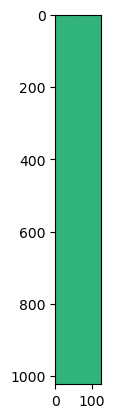

In [103]:
plt.imshow(shap_values[0,:,:])

In [105]:
print(shap_values) #they're legit all 0??
print(np.max(shap_values))

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
1.940718675541575e-06


# redo with a larger background

There's 3 things we can explore
1. mean
2. sum(abs)
3. pca 1st component after z scoring I think, look at Jan

In [1]:
import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F

# d_output = 161

tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

d_output = train_cfg['d_output'] 

backbone = DNAEmbeddingModel(**model_cfg)

decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/last.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
# loads model from ddp by removing prexix to single if necessary
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)

model_state_dict = state_dict["state_dict"]

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

#now adjust the backbone
embedding = torch.nn.Embedding(20, 128)
backbone.backbone.embeddings.word_embeddings = embedding #again a hack

# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)

decoder = decoder.to(device)
backbone = backbone.to(device)

In [2]:
#now we will load in the data, let's use the train as the background

ccre = DNaseDataset(max_length = 1024, split = 'train', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = True)


In [4]:
torch.manual_seed(420)
loader = torch.utils.data.DataLoader(ccre, batch_size=110, shuffle=True, num_workers=0)
batch = next(iter(loader))

In [5]:
#we need to modify net to take in the embeddings directly
class Net(torch.nn.Module):
    def __init__(self, backbone, decoder):
        super(Net, self).__init__()
        self.backbone = backbone  # Your pre-defined backbone
        self.decoder = decoder    # Your pre-defined decoder

    def forward(self, x):
        residual = None
        backbone = self.backbone
        # a_embed = backbone.backbone.embeddings.word_embeddings(x)
        a_embed = x #since we will embed it manually
        for layer in backbone.backbone.layers:
            a_embed, residual = layer(a_embed, residual)
        dropped = backbone.backbone.drop_f(a_embed)
        residual = (dropped + residual) if residual is not None else dropped
        hidden_states = backbone.backbone.ln_f(residual.to(dtype=backbone.backbone.ln_f.weight.dtype))
        
        # x = self.backbone(x)  # Pass input through backbone
        x = self.decoder(x)   # Pass backbone's output through decoder
        return x

In [6]:
inputs, targets = batch
background = inputs[:100]
test_input = inputs[100:]

#now embed the inputs
background_embed = backbone.backbone.embeddings.word_embeddings(background)
test_input_embed = backbone.backbone.embeddings.word_embeddings(test_input)
print(background_embed.shape) #seems about right

torch.Size([100, 1023, 128])


In [8]:
#now we can use the explainer
import shap
net = Net(backbone, decoder)
explainer = shap.DeepExplainer(net, background_embed)

In [9]:
shap_values = explainer.shap_values(test_input_embed) #for 100 background tested on 10 samples it takes 1.5 minutes

In [10]:
shap_values.shape #it's the same size as the embedding as we discussed previously, but let's focus on individual samples

(10, 1023, 128)

Text(0.5, 1.0, 'SHAP values for the first sample')

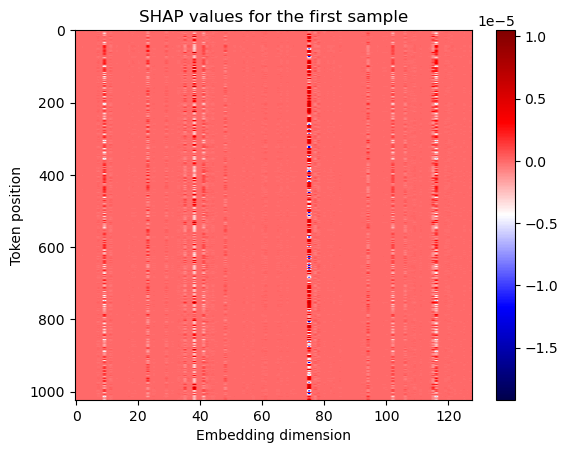

In [14]:
#let's plot the shap values for the first sample
import matplotlib.pyplot as plt
#and make it square
plt.imshow(shap_values[0,:,:], cmap='seismic', aspect='auto')
plt.colorbar()
plt.xlabel('Embedding dimension')
plt.ylabel('Token position')
plt.title('SHAP values for the first sample')

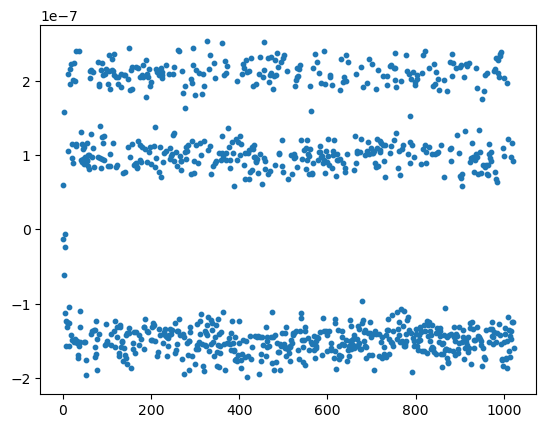

In [17]:
#let's plot the mean across the embedding dimensions
plt.scatter(range(1023), shap_values[0,:,:].mean(axis=1), s = 10)

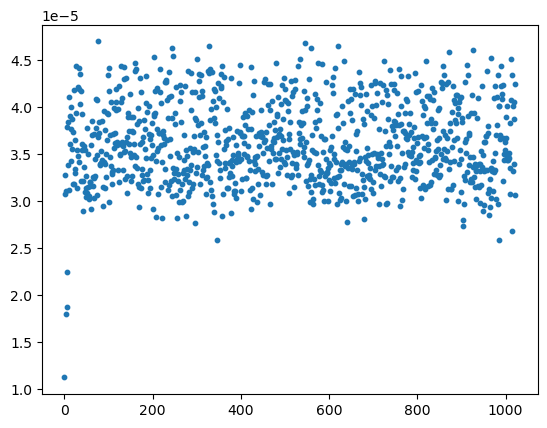

In [21]:
#let's plot the sum of the absolute values
import numpy as np
plt.scatter(range(1023), np.abs(shap_values[0,:,:]).sum(axis=1), s = 10)

In [24]:
tempshap = shap_values[0,:,:]
print(tempshap.shape)
tempshap.mean(axis=0).shape #it is the mean for each embedding dimension

(1023, 128)


(128,)

(1023, 128)


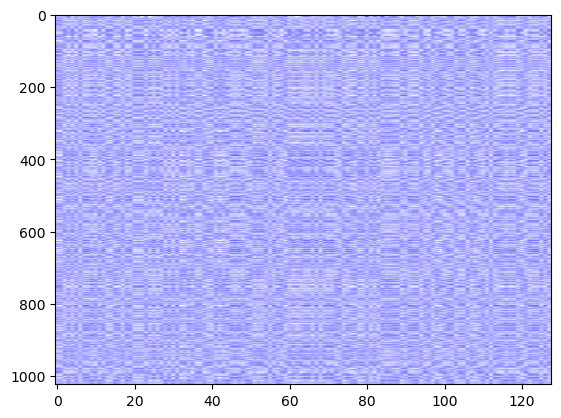

In [26]:
#let's first zscore
shap_values_z = (tempshap - tempshap.mean(axis=0)) / tempshap.std(axis=0)
print(shap_values_z.shape)
plt.imshow(shap_values_z, cmap='seismic', aspect='auto')

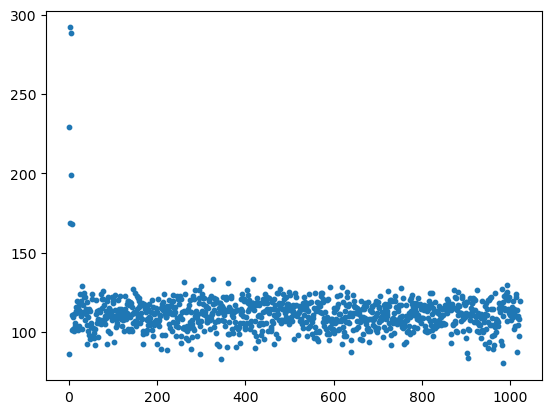

In [27]:
#now let's try summing the absolute values
plt.scatter(range(1023), np.abs(shap_values_z).sum(axis=1), s = 10)

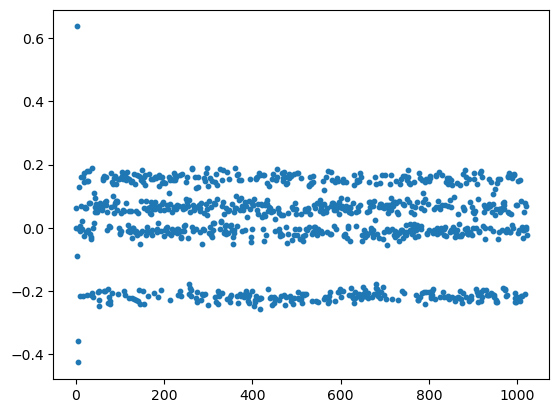

In [28]:
#and again the mean
plt.scatter(range(1023), shap_values_z.mean(axis=1), s = 10)

In [30]:
#and let's do pca on the shap values
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(shap_values_z)
pca_shap = pca.transform(shap_values_z)
print(pca_shap.shape)
#find amount of variance explained
print(pca.explained_variance_ratio_)

(1023, 1)
[0.44179143]


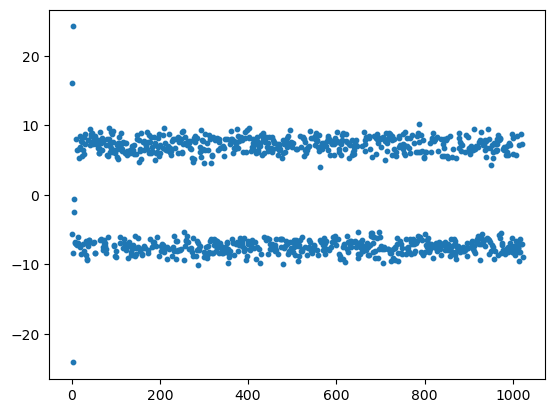

In [31]:
#and plot
plt.scatter(range(1023), pca_shap, s = 10)

In [36]:
#try the pca withou zscoring
pca = PCA(n_components=1)
pca.fit(tempshap)
pca_shap = pca.transform(tempshap)
print(pca_shap.shape)
#find amount of variance explained
print(pca.explained_variance_ratio_)

(1023, 1)
[0.58999304]


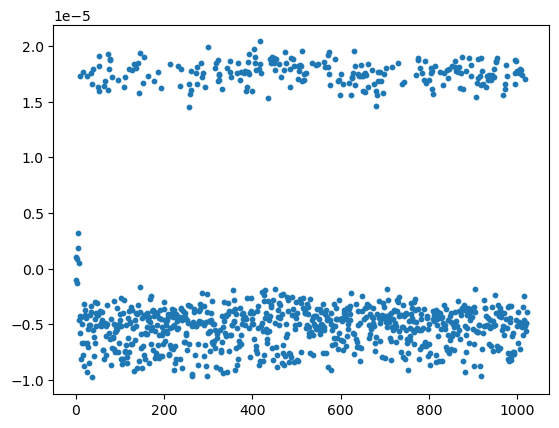

In [37]:
#and plot
plt.scatter(range(1023), pca_shap, s = 10)

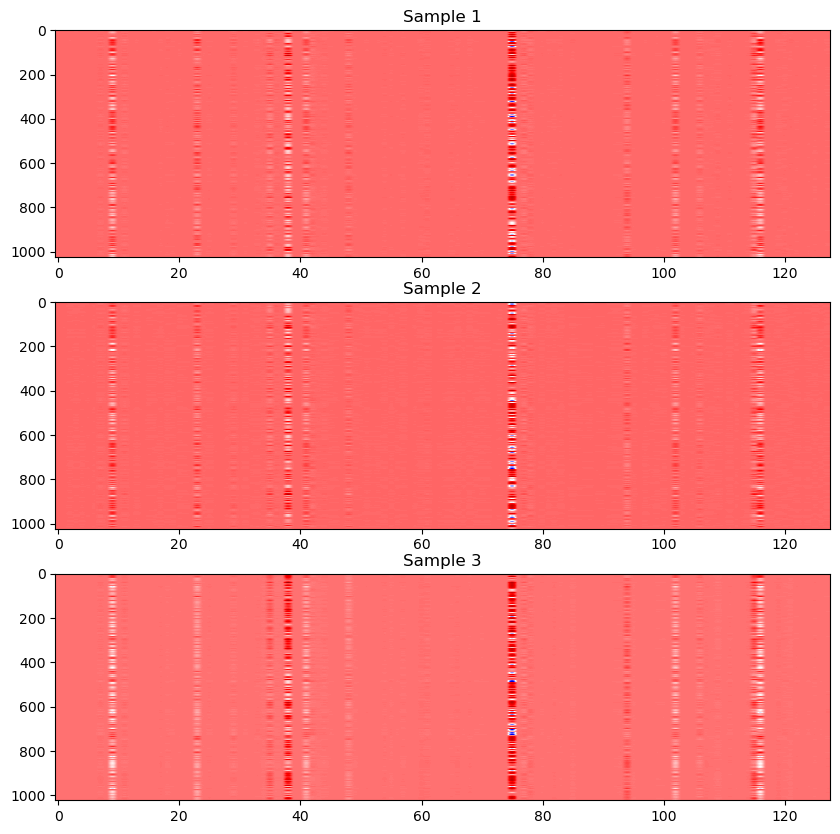

In [35]:
#let's look at shap values for the three samples as a subplots
fig, axs = plt.subplots(3, 1, figsize=(10,10))
for i in range(3):
    axs[i].imshow(shap_values[i,:,:], cmap='seismic', aspect='auto')
    axs[i].set_title(f'Sample {i+1}')
# plt.imshow(shap_values[1,:,:], cmap='seismic', aspect='auto')
# plt.colorbar()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
for i in range(3):
    axs[i].imshow(shap_values[i,:,:], cmap='seismic', aspect='auto')
    axs[i].set_title(f'Sample {i+1}')
    

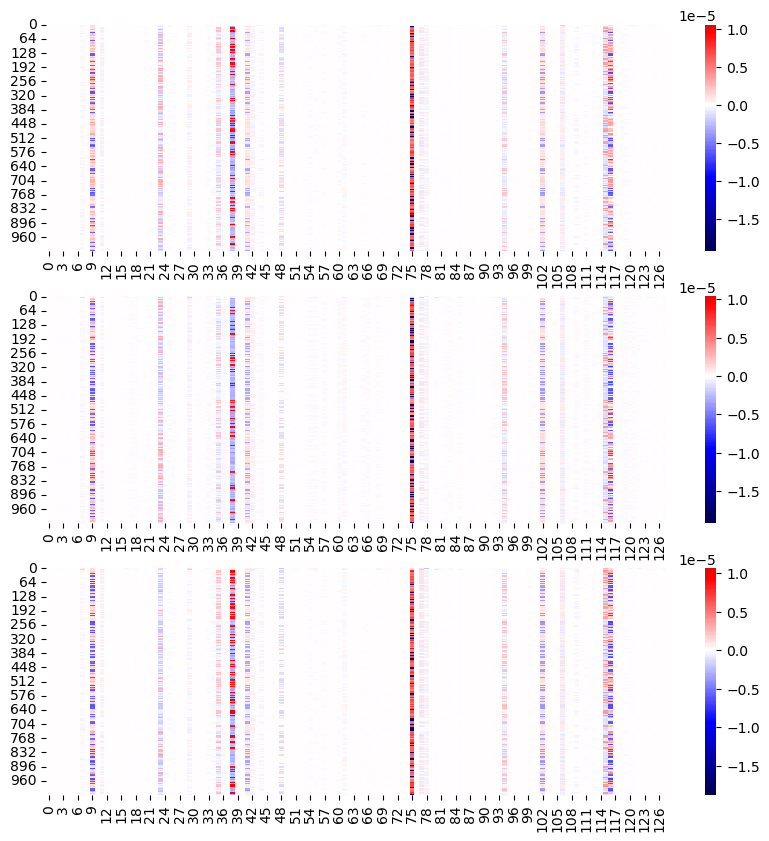

In [57]:
import seaborn as sns
fig,axs = plt.subplots(3,1, figsize=(10,10))
for i in range(3):
    sns.heatmap(shap_values[i,:,:], cmap='seismic', center=0, ax = axs[i])
# sns.heatmap(shap_values[0,:,:], cmap='seismic', center=0)


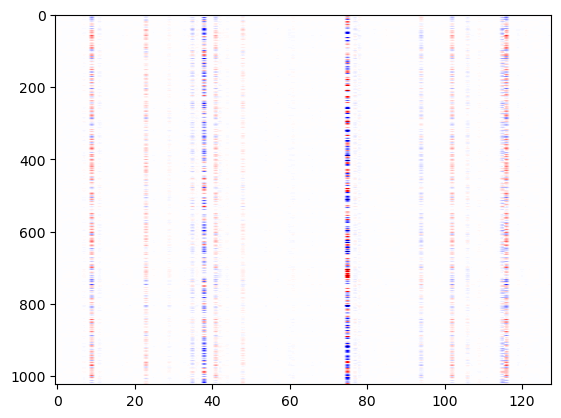

In [38]:
dif = shap_values[0,:,:] - shap_values[2,:,:]
plt.imshow(dif, cmap='seismic', aspect='auto')

(1023, 1)
[0.56021532]


Text(0.5, 1.0, 'PCA of SHAP values')

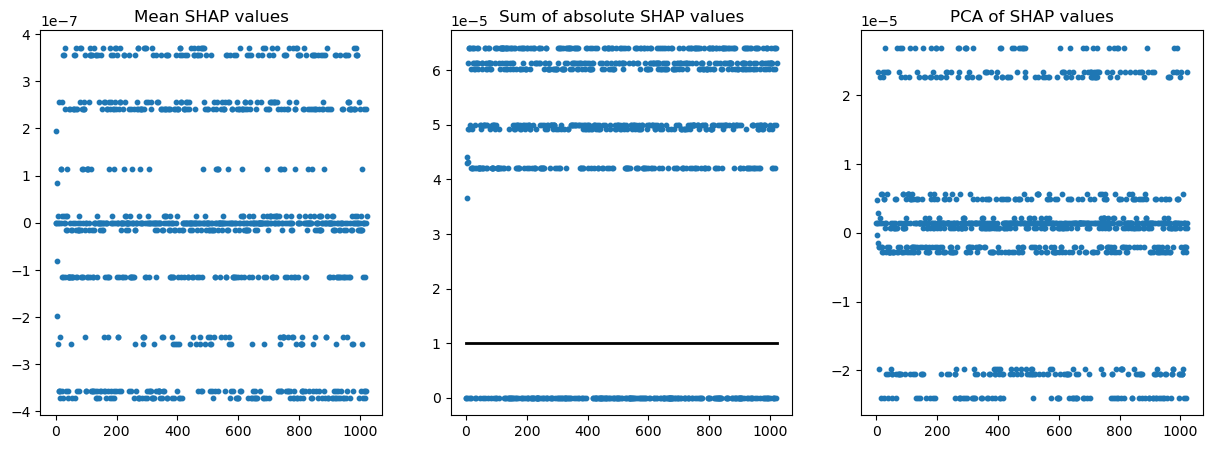

In [46]:
#now do the mean and sum and pca for the dif
figs, axs = plt.subplots(1, 3, figsize=(15,5))
#mean
axs[0].scatter(range(1023), dif.mean(axis=1), s = 10)
#add title
axs[0].set_title('Mean SHAP values')
#sum
axs[1].scatter(range(1023), np.abs(dif).sum(axis=1), s = 10)
axs[1].plot([0, 1023], [1e-5, 1e-5], 'k-', lw=2)
axs[1].set_title('Sum of absolute SHAP values')
#pca
pca = PCA(n_components=1)
pca.fit(dif)
pca_dif = pca.transform(dif)
print(pca_dif.shape)
#find amount of variance explained
print(pca.explained_variance_ratio_)
axs[2].scatter(range(1023), pca_dif, s = 10)
axs[2].set_title('PCA of SHAP values')

In [47]:
#let's check the sum more specifically, how many are below 1e-5
print(np.sum(np.abs(dif).sum(axis=1) < 1e-5)) #so 247 of them are below 1e-5, meaning most are labeled as significant...

#now check how many have abs value pca values that are greater than 1e-5
print(np.sum(np.abs(pca_dif) > 1e-5)) #so only 336, that's much more useful!

247
336


<BarContainer object of 1023 artists>

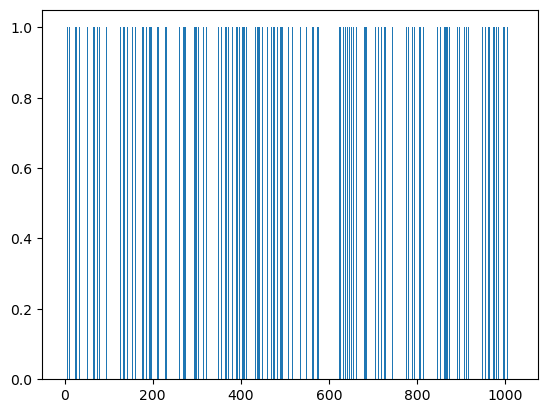

In [51]:
#let's plot a bar plot of 0 or 1 if it's above the threshold
plt.bar(range(1023), np.squeeze(np.abs(pca_dif) > 1e-5)) #not really useful, but it's potentially something, no clue how to go about interpreting this

# SHAP utils

In [1]:
#we will create a utility function for shap called shap_utils.py
#you define several attributes, and then it will load the data to be able to access the shap values

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F
import shap

class ShapUtils():
    def __init__(self, model_type, ckpt_path, cfg = None, split = 'train', filter=True, ignore_embed = True):
        type_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes', 'DNase']
        if model_type not in type_list:
            raise ValueError('Model type not recognized')
        self.type = model_type
        
        #check to see the type, and then load the right tokenizer, class and cfg
        if self.type == 'DNase':
            from src.dataloaders.datasets.DNase_dataset import DNaseDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
                
        elif self.type == 'DNase_allcelltypes':
            from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'

        elif self.type == 'Dnase_ctst':
            from src.dataloaders.datasets.DNase_ctst_dataset import DNaseCtstDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst.yaml'

        else:
            raise ValueError('Model type not recognized')

        #now we load the model and dataset

        # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.dataset = DatasetClass(max_length = 1024, split = split, tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = filter)
        cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        
        train_cfg = cfg['train']  # grab section `train` section of config
        model_cfg = cfg['model_config']  # grab the `model` section of config
        d_output = train_cfg['d_output'] 
        backbone = DNAEmbeddingModel(**model_cfg)
        decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
        state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
        decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

        #now adjust the backbone if needed
        if self.type == 'DNase':
            embedding = torch.nn.Embedding(20, 128)
            backbone.backbone.embeddings.word_embeddings = embedding #again a hack

        # now actually load the state dict to the decoder and backbone separately
        decoder.load_state_dict(decoder_state_dict, strict=True)
        backbone.load_state_dict(model_state_dict, strict=True)

        # decoder = decoder.to(self.device)
        # backbone = backbone.to(sdevice)

        self.backbone = backbone
        self.decoder = decoder

        self.create_model(ignore_embed)
        # Net(backbone, decoder)

    def create_model(self, ignore_embed = False):
        #here we can define the model that will be used for the SHAP analysis
        if ignore_embed:
            self.model = NetNoEmbed(self.backbone, self.decoder)
        else:
            self.model = Net(self.backbone, self.decoder)

    def load_data(self, batch_size = 110, remainder = 10):
        loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        batch = next(iter(loader))
        inputs, targets = batch
        self.background = inputs[:batch_size - remainder]
        self.test_input = inputs[batch_size-remainder:]
        self.background_embed = self.backbone.backbone.embeddings.word_embeddings(self.background)
        self.test_input_embed = self.backbone.backbone.embeddings.word_embeddings(self.test_input)

    def shap_values(self, background = None, test_input = None):
        if background is None:
            background = self.background_embed
        if test_input is None:
            test_input = self.test_input_embed
        self.explainer = shap.DeepExplainer(self.model, background)
        shap_values = self.explainer.shap_values(test_input)
        return shap_values
         

class NetNoEmbed(torch.nn.Module):
    def __init__(self, backbone, decoder):
        super(NetNoEmbed, self).__init__()
        self.backbone = backbone  # Your pre-defined backbone
        self.decoder = decoder    # Your pre-defined decoder

    def forward(self, x):
        residual = None
        backbone = self.backbone
        # a_embed = backbone.backbone.embeddings.word_embeddings(x)
        a_embed = x #since we will embed it manually
        for layer in backbone.backbone.layers:
            a_embed, residual = layer(a_embed, residual)
        dropped = backbone.backbone.drop_f(a_embed)
        residual = (dropped + residual) if residual is not None else dropped
        hidden_states = backbone.backbone.ln_f(residual.to(dtype=backbone.backbone.ln_f.weight.dtype))
        
        # x = self.backbone(x)  # Pass input through backbone
        x = self.decoder(x)   # Pass backbone's output through decoder
        return x
    

#let's define a class that takes both elements
class Net(torch.nn.Module):
    def __init__(self, backbone, decoder):
        super(Net, self).__init__()
        self.backbone = backbone  # Your pre-defined backbone
        self.decoder = decoder    # Your pre-defined decoder

    def forward(self, x):
        x, _ = self.backbone(x)  # Pass input through backbone
        x = self.decoder(x)   # Pass backbone's output through decoder
        return x

In [24]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/last.ckpt'
util = ShapUtils('DNase', ckpt_path)
util.load_data()


In [25]:
#now check to see if it returns the shap values
import shap
shap_values = util.shap_values()
shap_values.shape #it's the same size as the embedding as we discussed previously, but let's focus on individual samples

(10, 1023, 128)

In [21]:
print(util.background_embed.shape) #this is the right shape
print(util.test_input_embed.shape) #this is the right shape
print(util.model) #this is none, this is definitely the issue
util.tokenizer._vocab_int_to_str #is also correct!

#ah was defining self.model as what was returned when I just defined self.model directly in the function, so it was None

torch.Size([100, 1023, 128])
torch.Size([10, 1023, 128])
None


{0: '[CLS]',
 1: '[SEP]',
 2: '[BOS]',
 3: '[MASK]',
 4: '[PAD]',
 5: '[RESERVED]',
 6: '[UNK]',
 7: 'A',
 8: 'C',
 9: 'G',
 10: 'T',
 11: 'N',
 12: 'S',
 13: 'U',
 14: 'V',
 15: 'W',
 16: 'X',
 17: 'Y',
 18: 'Z'}

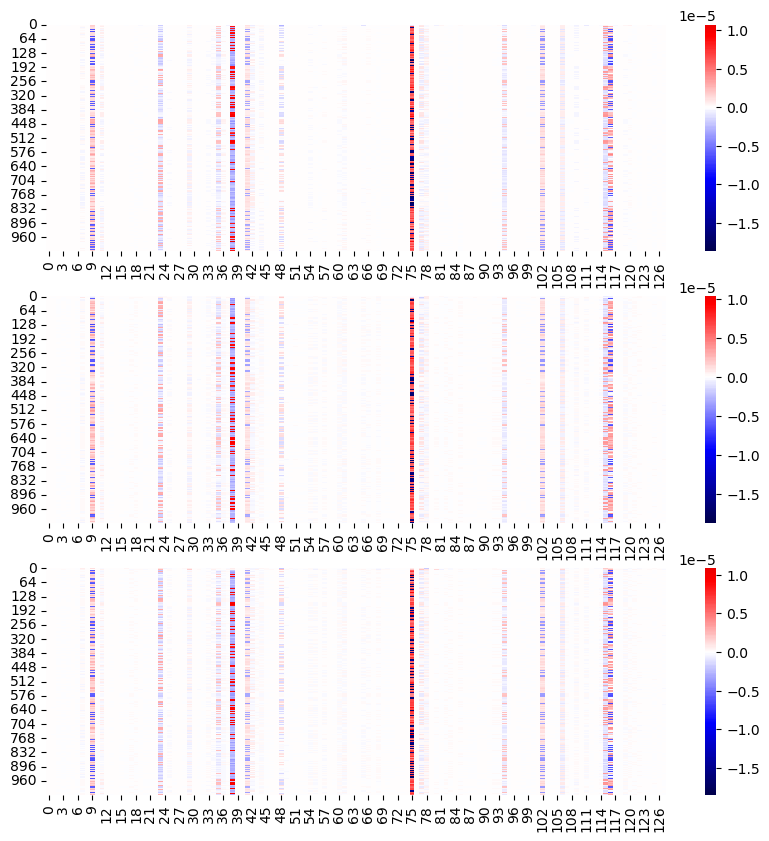

In [28]:
#let's again view it, can add some utility visualization functions as well!
import seaborn as sns
import matplotlib.pyplot as plt
fig,axs = plt.subplots(3,1, figsize=(10,10))
for i in range(3):
    sns.heatmap(shap_values[i,:,:], cmap='seismic', center=0, ax = axs[i])

In [38]:
#let's now make one that uses the allcelltypes model
#in total takes like 30+ minutes or so, because this model is a decent bit larger, but we will focus on the first sample as the background just to test
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-17/09-34-21-368888/checkpoints/last.ckpt'
util_multi = ShapUtils('DNase_allcelltypes', ckpt_path)
util_multi.load_data()
shap_values_multi = util_multi.shap_values(background = util_multi.background_embed[0].unsqueeze(0), test_input = util_multi.test_input_embed)
shap_values_multi.shape #it's the same size as the embedding as we discussed previously, but let's focus on individual samples

AttributeError: 'list' object has no attribute 'shape'

In [40]:
len(shap_values_multi)

161

In [41]:
shap_values_multi[0].shape

(10, 1023, 128)

In [37]:
#sanity check the model
print(util_multi.background_embed.shape) #this is the right shape
single_sample = util_multi.background_embed[0].unsqueeze(0)
print(single_sample.shape) #this is the right shape
#put it through the model
with torch.no_grad():
    out = util_multi.model(single_sample)
print(out.shape) #this is the right shape

torch.Size([100, 1023, 128])
torch.Size([1, 1023, 128])
torch.Size([1, 161])


# save out shap integrated

Let's save out the shap values by first testing to see if it's possible


In [2]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/last.ckpt'
util = ShapUtils('DNase', ckpt_path)
util.load_data()

#now check to see if it returns the shap values
import shap
shap_values = util.shap_values()
shap_values.shape #it's the same size as the embedding as we discussed previously, but let's focus on individual samples

(10, 1023, 128)

In [3]:
util.explainer

In [5]:
#try to save with pickle
import pickle
with open('/data/leslie/sarthak/data/shap_explainer_test.pkl', 'wb') as f:
    pickle.dump(util.explainer, f)

In [6]:
#and try to load it
a = pickle.load(open('/data/leslie/sarthak/data/shap_explainer_test.pkl', 'rb'))
a

In [7]:
a.shap_values(util.test_input_embed) #only saves 30 seconds?!?
#should still save time in th elong run

array([[[-4.10766532e-10,  2.07988715e-09,  2.52628070e-08, ...,
         -7.29473228e-08,  2.34716619e-08,  9.17274576e-08],
        [ 6.42463860e-09,  2.81782793e-08, -1.29548255e-07, ...,
         -1.65655692e-07, -4.45868835e-08,  6.80135130e-08],
        [-2.82629609e-09,  4.38275016e-09,  4.60066225e-08, ...,
          2.60331319e-07, -1.07661258e-08, -1.39608645e-07],
        ...,
        [-2.92285396e-09, -1.18045129e-08,  2.50918148e-08, ...,
          9.38940801e-08,  4.31155733e-08, -2.98753307e-08],
        [-3.19516325e-09, -1.27688482e-08,  2.90986062e-08, ...,
          1.05720375e-07,  4.66976324e-08, -2.83060650e-08],
        [ 1.41336054e-10, -2.43268961e-09, -4.65995633e-08, ...,
         -7.41794821e-08,  7.46225126e-09, -1.12517945e-07]],

       [[-4.10766532e-10,  2.07988715e-09,  2.52628070e-08, ...,
         -7.29473228e-08,  2.34716619e-08,  9.17274576e-08],
        [-2.45338705e-09, -1.05100080e-08,  4.24763371e-08, ...,
          1.15611485e-07,  2.47106886e

In [12]:
#the final thing to do is to find some way to partition the dataset based on the number of cCREs
#we want roiughly 1000, so let's choose every 100th cCRE to be in the background, and the rest to be in the test_input
#we will do this for the DNase_allcelltypes model
len(util.dataset)/util.dataset.cell_types

856076.0

In [13]:
util.dataset[0]

(tensor([12, 13, 14,  ...,  7, 10,  9]), tensor([-10.]))

In [26]:
util.dataset[0][0].shape

torch.Size([1023])

In [14]:
a,b = util.dataset[0:2]
print(a)
print(b)

TypeError: '<' not supported between instances of 'slice' and 'int'

In [36]:
#let's do this with a for loop instead

#first assign 10% of the indices to be in the background
import numpy as np
indices = np.arange(int(len(util.dataset)/util.dataset.cell_types))
print(indices.shape)
np.random.seed(420)
np.random.shuffle(indices)
background_indices = indices[:int(len(indices)/10000)]
test_input_indices = indices[int(len(indices)/10000):]
print(background_indices.shape, test_input_indices.shape)
print(test_input_indices)

(856076,)
(85,) (855991,)
[306045 352837 758570 ... 676415 643462 193608]


In [25]:
torch.zeros((len(background_indices))).shape

torch.Size([8560])

In [37]:
#let's test it for this dataset
background = torch.zeros((len(background_indices)*161, 1023))
# test_input = torch.zeros((len(test_input_indices)*161, 1023))
for i, idx in enumerate(background_indices): #now we get an index, but this is the cCRE index, need to then loop through all of the cell types
    for j in range(161):
        background[i*161 + j], _ = util.dataset[idx*161 + j]
# for i, idx in enumerate(util.test_input_indices):
#     for j in range(161):
#         test_input[i*161 + j], _ = util.dataset[idx*161 + j]

In [31]:
558353710992 / 1e9

558.353710992

In [35]:
!top

=top - 17:22:05 up 100 days,  6:58,  0 users,  load average: 0.11, 0.17, 0.28
Tasks: 799 total,   1 running, 798 sleeping,   0 stopped,   0 zombie
%Cpu(s):  0.1 us,  0.2 sy,  0.0 ni, 99.7 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 79095846+total, 54016812+free, 24734118+used,  3449140 buff/cache
KiB Swap:        0 total,        0 free,        0 used. 54115155+avail Mem 

   PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND    
 65129 tiwaris2  20   0  173480   2940   1592 R  12.5  0.0   0:00.24 top        
     9 root      20   0       0      0      0 S   6.2  0.0 459:55.39 rcu_sched  
  5900 root       0 -20   49.1g   9.4g 550792 S   6.2  1.2   3309:45 mmfsd      
     1 root      20   0  191412   3536   1724 S   0.0  0.0  66:16.85 systemd    
     2 root      20   0       0      0      0 S   0.0  0.0   0:09.83 kthreadd   
     4 root       0 -20       0      0      0 S   0.0  0.0   0:00.00 kworker/0+ 
     6 root      20   0       0      0      0 S   0.

In [39]:
background.shape

torch.Size([13685, 1023])

In [41]:
#check if any rows or columns are all 0
print(torch.sum(background, axis = 1))
print(torch.sum(background, axis = 0))


tensor([8794., 8794., 8794.,  ..., 8791., 8791., 8791.])
tensor([165835., 194735., 210715.,  ..., 116242., 117852., 118013.])


# updated shap.utils
i updated my utils and put it in shap.utils, let's test it now

In [52]:
import sys
sys.path.append('/lila/data/leslie/sarthak/hyena/hyena-dna/shap')
from shap_utils import ShapUtils
util = ShapUtils('DNase', ckpt_path, percentage_background = 1/10000)

In [46]:
import os
os.getcwd()

'/lila/data/leslie/sarthak/hyena/hyena-dna'

In [47]:
os.listdir('/data/leslie/sarthak/hyena/hyena-dna/shap')

['shap_utils.py']

In [53]:
#now check the shap values
util.load_from_indices()

In [56]:
util.background.shape #background indices is 85, so 85 total ccres and all the cell types for them

torch.Size([13685, 1023])

In [55]:
85*161 #had this above, not sure what's up

13685

In [61]:
util.background.dtype

torch.float32

In [62]:
print(util.background.shape)
print(util.background)

torch.Size([13685, 1023])
tensor([[12., 13., 14.,  ...,  7.,  9., 10.],
        [12., 13., 14.,  ...,  7.,  9., 10.],
        [12., 13., 14.,  ...,  7.,  9., 10.],
        ...,
        [13., 16., 15.,  ...,  8.,  9.,  9.],
        [13., 16., 17.,  ...,  8.,  9.,  9.],
        [13., 16., 17.,  ...,  8.,  9.,  9.]])


In [ ]:
#It is float

In [59]:
util.background_embed = util.backbone.backbone.embeddings.word_embeddings(util.background)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [63]:
# Ahh, we need it to be long
util.background = util.background.long()
util.background_embed = util.backbone.backbone.embeddings.word_embeddings(util.background)

In [64]:
util.background_embed.shape

torch.Size([13685, 1023, 128])

In [65]:
import shap
explainer = shap.DeepExplainer(util.model, util.background_embed)

: 

# edited the utils file, try again

In [2]:
#list current sys paths
import sys
sys.path

['/lila/data/leslie/sarthak/hyena/hyena-dna',
 '/data/leslie/sarthak/environments/hyena-dna/lib/python311.zip',
 '/data/leslie/sarthak/environments/hyena-dna/lib/python3.11',
 '/data/leslie/sarthak/environments/hyena-dna/lib/python3.11/lib-dynload',
 '',
 '/data/leslie/sarthak/environments/hyena-dna/lib/python3.11/site-packages']

In [5]:
from shap_utils.shap_utils import ShapUtils
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/last.ckpt'
util = ShapUtils('DNase', ckpt_path, percentage_background = 1/10000)

In [6]:
util.load_from_indices()

In [7]:
util.background_embed.shape

torch.Size([13685, 1023, 128])

In [8]:
import shap
explainer = shap.DeepExplainer(util.model, util.background_embed)

In [9]:
#let's dump the explainer
import pickle
with open('/data/leslie/sarthak/data/shap_explainer_85ccre_DNase.pkl', 'wb') as f:
    pickle.dump(explainer, f)

In [1]:
#now let's try it with the all cell types
from shap_utils.shap_utils import ShapUtils
import shap
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-17/09-34-21-368888/checkpoints/last.ckpt'
util = ShapUtils('DNase_allcelltypes', ckpt_path, percentage_background = 1/10000)

In [2]:
util.load_from_indices()

In [3]:
util.background_embed.shape

torch.Size([85, 1023, 128])

In [4]:
explainer = shap.DeepExplainer(util.model, util.background_embed)
import pickle
with open('/data/leslie/sarthak/data/shap_explainer_85ccre_DNase_allcelltypes.pkl', 'wb') as f:
    pickle.dump(explainer, f)

In [5]:
#test to make sure
a,b = util.dataset[0]
print(a.shape)

shap_values = explainer.shap_values(a.unsqueeze(0))
print(len(shap_values))

torch.Size([1023])


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [6]:
#first embed
a_embed = util.backbone.backbone.embeddings.word_embeddings(a.unsqueeze(0)) #15 minute sfor 1 ccre
print(a_embed.shape)
shap_values = explainer.shap_values(a_embed)

torch.Size([1, 1023, 128])


In [7]:
print(len(shap_values))

161


In [8]:
print(shap_values[0].shape)

(1, 1023, 128)
